In [1]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [2]:

# -------------------- Data Loading --------------------
def load_data(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File '{filepath}' not found.")
    df = pd.read_csv(filepath)
    print(f"✅ Dataset loaded from '{filepath}' with shape: {df.shape}")
    return df


In [3]:
def visualize_missing_data(df, title="Missing Values"):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
    plt.title(title, fontsize=16)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()


In [4]:
def handle_missing_values(df):
    print("📌 Visualizing missing data BEFORE handling:")
    visualize_missing_data(df, title="Before Handling Missing Values")

    # ---- Handle numeric columns
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
    for col in numeric_cols:
        if df[col].isnull().any():
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)
            print(f"🔧 Filled missing numeric values in '{col}' with mean: {mean_val:.4f}")

    # ---- Handle categorical columns
    cat_cols = df.select_dtypes(include=["object"]).columns
    for col in cat_cols:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"🔧 Filled missing categorical values in '{col}' with mode: {mode_val}")

    print(" All missing values handled.")
    print(" Visualizing missing data AFTER handling:")
    visualize_missing_data(df, title="After Handling Missing Values")

    return df


In [5]:

# -------------------- Exploratory Data Analysis --------------------
def perform_eda(df):
    print("\n📊 Performing EDA...")

    # Basic Statistics
    print("\nBasic Statistics (for numeric features):")
    print(df.describe())

    # Checking for class imbalance in target variable
    print("\nTarget Variable Distribution (Fraud vs Non-Fraud):")
    print(df['is_fraudulent'].value_counts())

    # Fraudulent vs Non-Fraudulent
    plt.figure(figsize=(6, 4))
    sns.countplot(x="is_fraudulent", data=df, palette="Set2")
    plt.title("Fraudulent vs Non-Fraudulent Transactions")
    plt.xlabel("Is Fraudulent?")
    plt.ylabel("Count")
    plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
    plt.tight_layout()
    plt.show()

    # Transaction Amount Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df["transaction_amount"], bins=50, kde=True)
    plt.title("Transaction Amount Distribution")
    plt.xlabel("Transaction Amount")
    plt.tight_layout()
    plt.show()

    # Boxplot: Fraud vs Amount
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="is_fraudulent", y="transaction_amount", data=df, palette="Set1")
    plt.title("Transaction Amount vs Fraud")
    plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
    plt.tight_layout()
    plt.show()

    # Heatmap for Correlation
    plt.figure(figsize=(6, 4))
    corr = df.select_dtypes(include=np.number).corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation")
    plt.tight_layout()
    plt.show()


In [6]:

# -------------------- Preprocessing --------------------
def create_preprocessing_pipeline(categorical_cols, numerical_cols):
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ]
    )
    return preprocessor


In [7]:

# -------------------- Plotting --------------------
def plot_confusion_matrices(results):
    plt.figure(figsize=(15, 10))
    for i, (name, result) in enumerate(results.items(), 1):
        plt.subplot(2, 2, i)
        sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.xticks([0.5, 1.5], ["Non-Fraud", "Fraud"])
        plt.yticks([0.5, 1.5], ["Non-Fraud", "Fraud"], rotation=0)
    plt.tight_layout()
    plt.show()


In [8]:

def plot_roc_curves(results):
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        if result["roc_curve"] is None:
            continue
        y_test, y_proba = result["roc_curve"]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.title("ROC Curves for Different Models", fontsize=16)
    plt.xlabel("False Positive Rate (FPR)", fontsize=12)
    plt.ylabel("True Positive Rate (TPR)", fontsize=12)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [9]:

# -------------------- Save Utility --------------------
def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"💾 Saved object to '{path}'")


✅ Dataset loaded from 'realistic_transactions.csv' with shape: (1000, 10)
Columns in the dataset:
Index(['transaction_id', 'customer_name', 'customer_email',
       'customer_location', 'merchant', 'transaction_amount',
       'transaction_purpose', 'card_type', 'fraud_score', 'is_fraudulent'],
      dtype='object')

Numerical features:
Index(['transaction_amount', 'fraud_score', 'is_fraudulent'], dtype='object')

Categorical features:
Index(['transaction_id', 'customer_name', 'customer_email',
       'customer_location', 'merchant', 'transaction_purpose', 'card_type'],
      dtype='object')
Missing values in each coloumns : 
transaction_id         0
customer_name          0
customer_email         0
customer_location      0
merchant               0
transaction_amount     0
transaction_purpose    0
card_type              0
fraud_score            0
is_fraudulent          0
dtype: int64
📌 Visualizing missing data BEFORE handling:


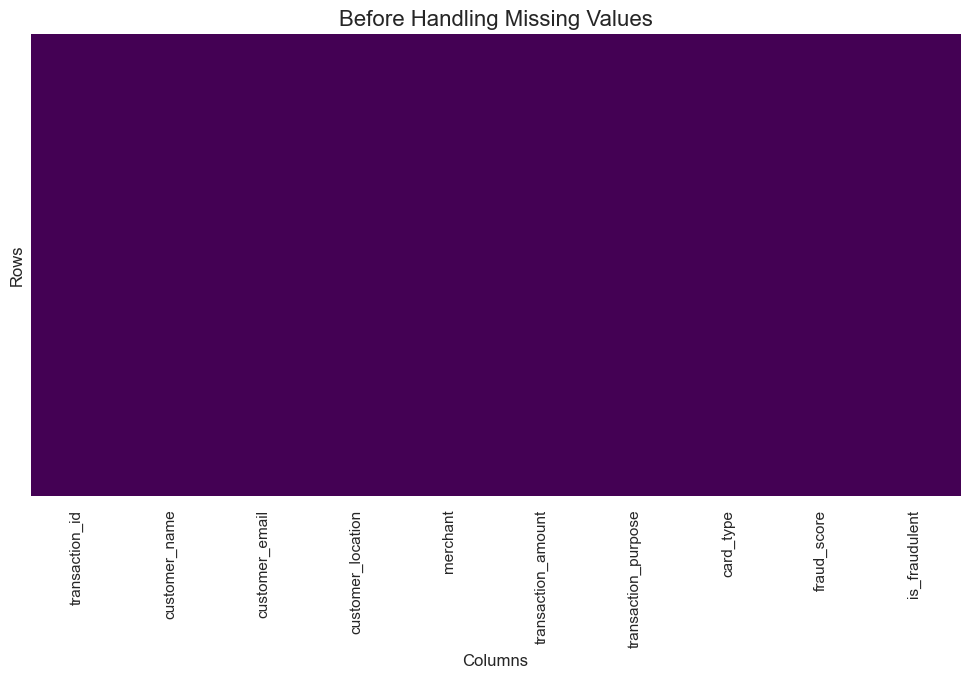

 All missing values handled.
 Visualizing missing data AFTER handling:


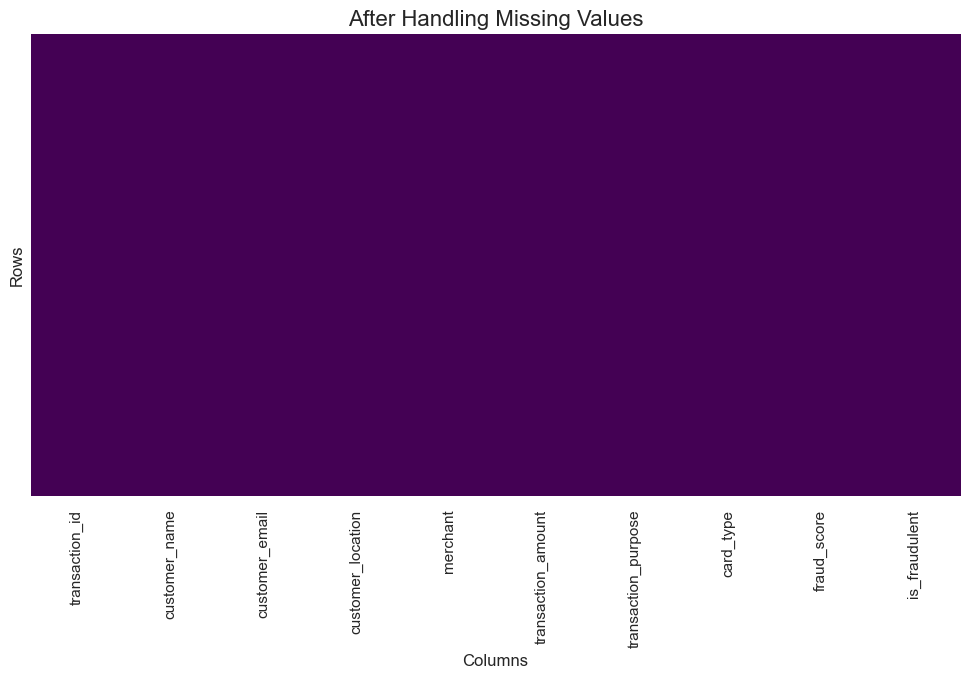


📊 Performing EDA...

Basic Statistics (for numeric features):
       transaction_amount  fraud_score  is_fraudulent
count         1000.000000  1000.000000    1000.000000
mean          2526.541630    50.054920       0.137000
std           1447.547872    28.269541       0.344019
min              5.230000     1.040000       0.000000
25%           1289.952500    26.427500       0.000000
50%           2522.490000    49.380000       0.000000
75%           3760.495000    75.082500       0.000000
max           4997.690000    99.450000       1.000000

Target Variable Distribution (Fraud vs Non-Fraud):
is_fraudulent
0    863
1    137
Name: count, dtype: int64


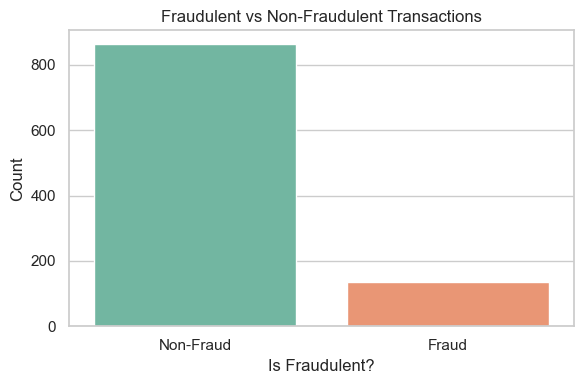

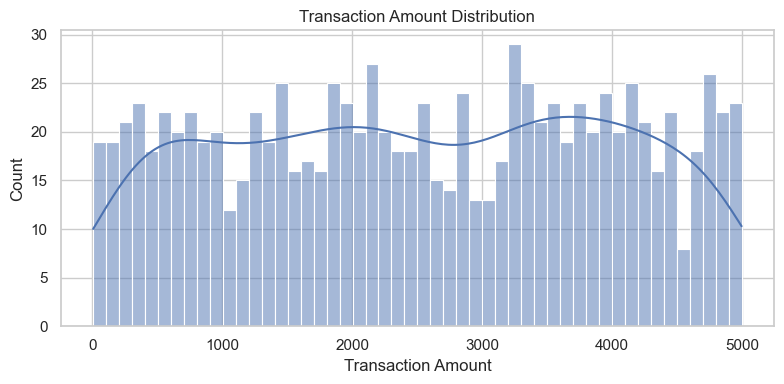

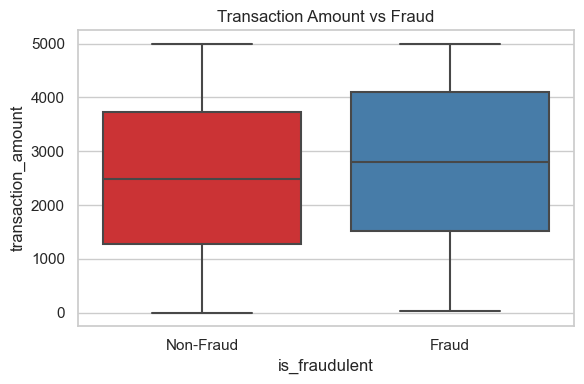

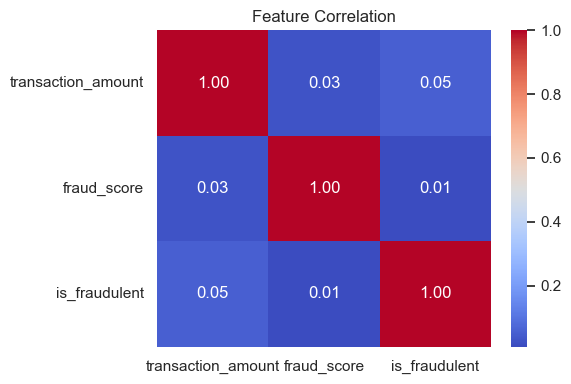

🔁 Resampled dataset shape: (1726, 1007), (1726,)

🔍 Tuning RandomForest...
✅ Best params for RandomForest: {'max_depth': None, 'n_estimators': 100}

🔍 Tuning XGBoost...
✅ Best params for XGBoost: {'learning_rate': 0.1, 'n_estimators': 100}

🔍 Tuning LogisticRegression...

🔍 Tuning SVM...

📈 Evaluating RandomForest...
RandomForest - Accuracy: 0.9537
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       259
           1       1.00      0.91      0.95       259

    accuracy                           0.95       518
   macro avg       0.96      0.95      0.95       518
weighted avg       0.96      0.95      0.95       518


📈 Evaluating XGBoost...
XGBoost - Accuracy: 0.9189
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       259
           1       0.97      0.86      0.91       259

    accuracy                           0.92       518
   macro avg       0.92      0.92      0.92       51

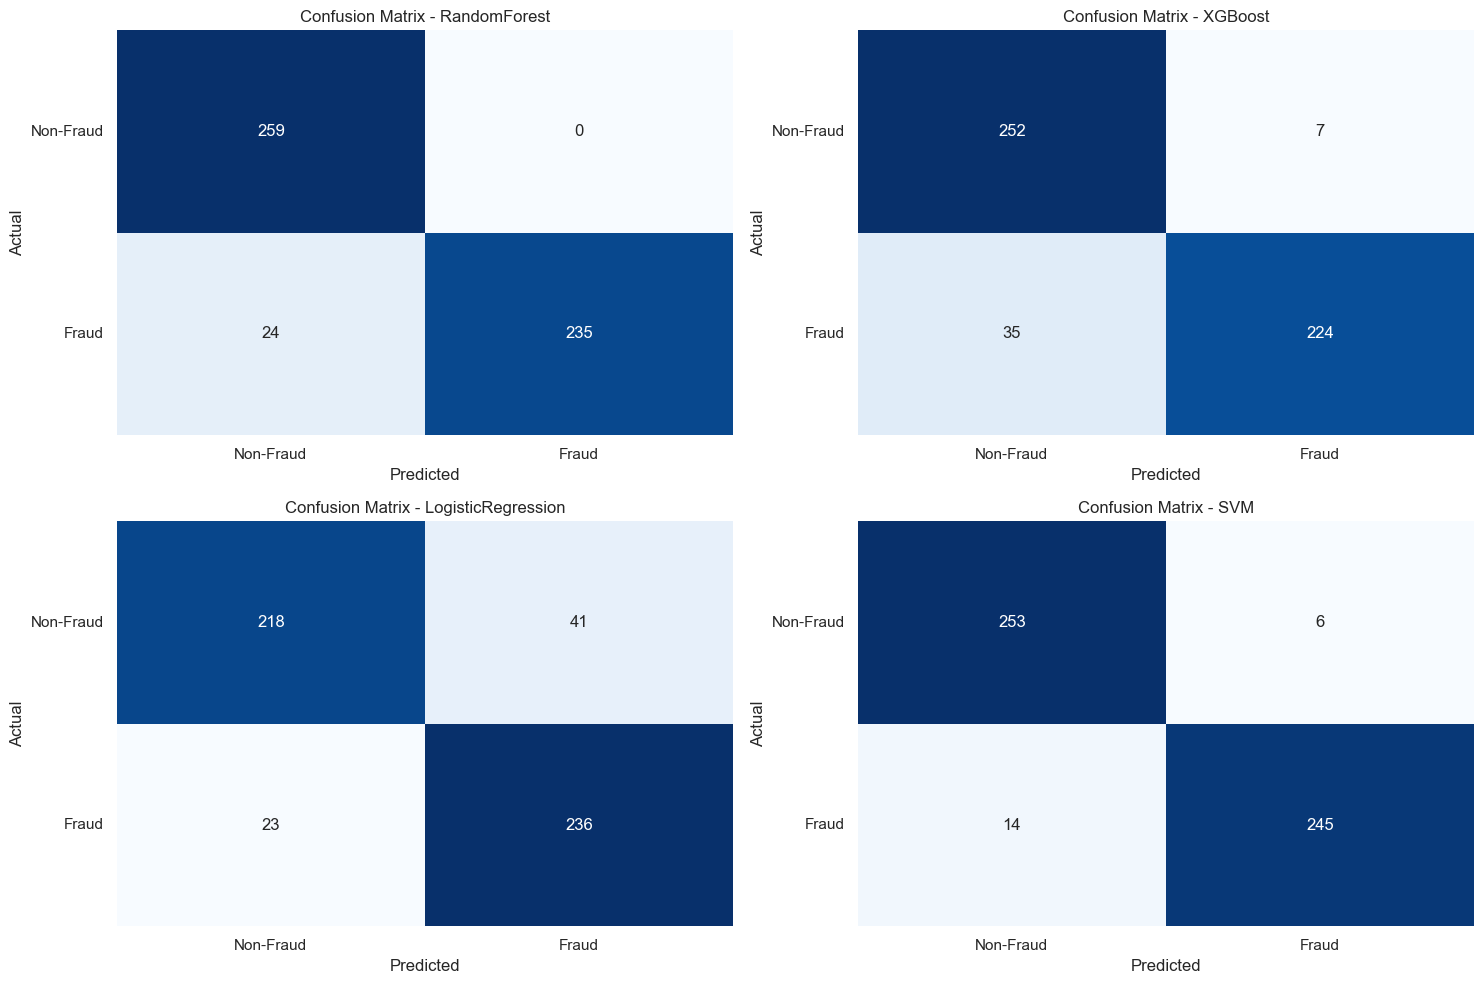

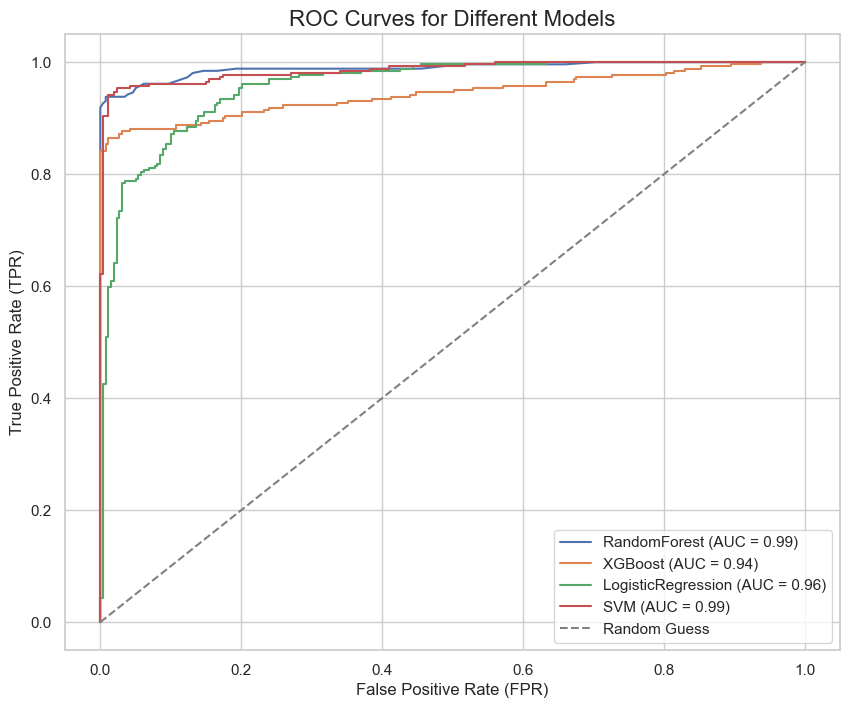


🏆 Best model: SVM
💾 Saved object to 'preprocessing_pipeline_smote.pkl'
💾 Saved object to 'fraud_model_smote.pkl'


In [10]:

# -------------------- Main Pipeline --------------------
def main():
    dataset_path = "realistic_transactions.csv"
    pipeline_path = "preprocessing_pipeline_smote.pkl"
    model_path = "fraud_model_smote.pkl"

    df = load_data(dataset_path)
    
    # 1. Display column names+
    print("Columns in the dataset:")
    print(df.columns)

    # 2. Identifying numerical features
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
    print("\nNumerical features:")
    print(numerical_features)

    # 3. Identifying categorical features
    categorical_features = df.select_dtypes(include=['object']).columns
    print("\nCategorical features:")
    print(categorical_features)

    print("Missing values in each coloumns : ")
    print(df.isnull().sum())
    df = handle_missing_values(df)
   
    perform_eda(df)

    categorical_cols = ["customer_location", "merchant", "transaction_purpose", "card_type"]
    numerical_cols = ["transaction_amount", "fraud_score"]

    # Prepare features and target
    X = df.drop(columns=["transaction_id", "customer_name", "customer_email", "is_fraudulent"])
    y = df["is_fraudulent"]

    preprocessor = create_preprocessing_pipeline(categorical_cols, numerical_cols)
    X_preprocessed = preprocessor.fit_transform(X)

    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)
    print(f"🔁 Resampled dataset shape: {X_resampled.shape}, {y_resampled.shape}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )

    models = {
        "RandomForest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "SVM": SVC(probability=True, random_state=42),
    }

    param_grids = {
        "RandomForest": {"n_estimators": [50, 100], "max_depth": [None, 10]},
        "XGBoost": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
    }

    tuned_models = {}
    for name, model in models.items():
        print(f"\n🔍 Tuning {name}...")
        if name in param_grids:
            grid = GridSearchCV(model, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"✅ Best params for {name}: {grid.best_params_}")
        else:
            model.fit(X_train, y_train)
            best_model = model
        tuned_models[name] = best_model

    results = {}
    for name, model in tuned_models.items():
        print(f"\n📈 Evaluating {name}...")
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        results[name] = {
            "accuracy": accuracy,
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1_score": report["weighted avg"]["f1-score"],
            "confusion_matrix": cm,
            "roc_curve": (y_test, y_proba) if y_proba is not None else None,
        }

        print(f"{name} - Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))

    plot_confusion_matrices(results)
    plot_roc_curves(results)

    best_model_name = max(results, key=lambda k: results[k]["accuracy"])
    print(f"\n🏆 Best model: {best_model_name}")
    save_pickle(preprocessor, pipeline_path)
    save_pickle(tuned_models[best_model_name], model_path)

# -------------------- Run --------------------
if __name__ == "__main__":
    main()
